# Replicating the Gillijns et al's EnKF example

## Forward simulation with central differences

$$\frac{\partial T(x,t)}{\partial t} = \alpha \frac{\partial^2 T(x,t)}{\partial x^2} + u(x,t)$$
with Boundaries
$$T(0,t)=T(L,t)=T(x,0)=300K$$

In [1]:
import numpy as np
import tqdm

from matplotlib import pyplot as plt

In [181]:
def forward_pass(params, x):
    
    sim_params = default_values()
    L = sim_params['L'] 
    dt = sim_params['dt']
    dx = sim_params['dx']
    
    alpha = params['alpha']
    beta = alpha*dt/dx/dx
    
    if beta > 0.5:
        raise ValueError(f'beta = {beta} gives unstable results for forward pass')
    
    T_0 = params['T_0']
    
    s1_pos = params['s1_pos']
    s2_pos = params['s2_pos']

    heat = params['heat']
    active = params['active']
    def f(t):
        if active:
            return heat
        
        return 0

    nsteps = len(x)
    
    # Generate matrix A for forward pass
    A = np.zeros((nsteps, nsteps))
    A[0,0] = A[-1,-1] = 1-2*beta
    A[0,1] = A[-1,-2] = beta
    for i in range(nsteps-2):
        A[i+1,i] = A[i+1,i+2] = beta
        A[i+1,i+1] = 1-2*beta

    # Generate source
    u = np.zeros(nsteps)
    u[int(s1_pos*nsteps)] = u[int(s2_pos*nsteps)] = dt

    # Boundary values
    left_boundary = np.zeros_like(u)
    left_boundary[0] = T_0*beta

    right_boundary = np.zeros_like(u)
    right_boundary[-1] = T_0*beta
    
    # Forward pass and return    
    return np.matmul(A, x) + u*f(t) + left_boundary + right_boundary

def default_values():
    return {'dx': 1, 'L': 100,
            'dt': 1, 'T': 1000}

In [182]:
%%time

np.random.seed(1234)

params = {'alpha' : 0.5,
          'T_0': 300, 
          's1_pos': 1/3,
          's2_pos': 2/3,
          'heat': 25,
          'active': True}

sim_params = default_values()
L = sim_params['L'] 
dt = sim_params['dt']
dx = sim_params['dx']
T = sim_params['T']

tar = np.arange(0,T, dt)
xar = np.arange(0,L, dx)
    
Xt = np.zeros((len(xar), len(tar)))
Xt[:,0] = 277

active_ar = np.random.uniform(0,1,len(tar)) > 0.5
multiply_ar = np.random.uniform(0,1,len(tar)) > 0.5
for tix, t in tqdm.tqdm(enumerate(tar[1:])):
    params['active'] = active_ar[tix]
    Xt[:,tix+1] = forward_pass(params, Xt[:,tix])

999it [00:24, 41.00it/s]


CPU times: user 4.39 s, sys: 19.5 s, total: 23.9 s
Wall time: 24.4 s


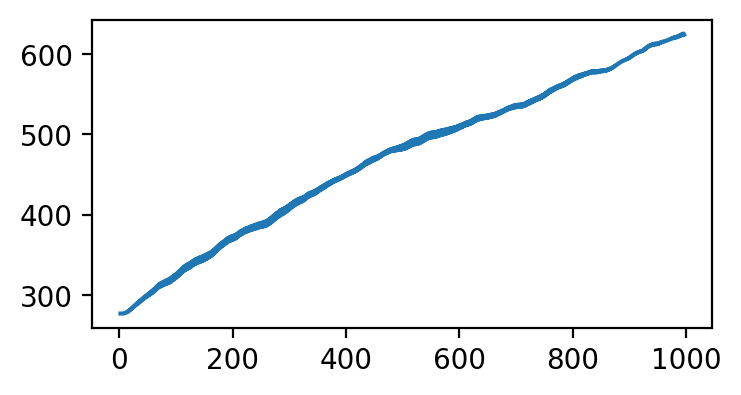

In [195]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

window_size = 5
yar = np.convolve(Xt[60,:], np.array([1/window_size]*window_size), mode='valid')
ax.plot(tar[(window_size//2):-(window_size//2)], yar)

# ax.plot(tar, Xt[33,:])

# ax.set_
# ax.set_xlim(400,450)
# ax.plot(xar, Xt[:,10])

In [45]:
# vary heat input at two locations randomly

sim_params = default_values()
L = sim_params['L'] 
dt = sim_params['dt']
dx = sim_params['dx']
T = sim_params['T']

tar = np.arange(0,T, dt)
xar = np.arange(0,L, dx)

s1_posar = np.random.normal(1/3, 0.06, size=len(tar))
s2_posar = np.random.normal(2/3, 0.06, size=len(tar))
heat_ar = abs(np.random.normal(25, 10, size=len(tar)))

Xt_sim = np.zeros((len(xar), len(tar)))
Xt_sim[:,0] = 277

sensor_ix = [9, 19, 29, 39, 49, 59, 69, 79, 89]
Y = np.zeros((len(sensor_ix), len(tar)))
Y[:,0] = np.random.normal(Xt_sim[sensor_ix, 0], 5)

for tix, t in tqdm.tqdm(enumerate(tar[1:])):
    params = {'alpha': 0.5,
              'T_0': 300,
              's1_pos': 1/3,
              's2_pos': 2/3,
              'heat': heat_ar[tix]}
    
    Xt_sim[:,tix+1] = forward_pass(params, Xt_sim[:,tix])
    Y[:,tix+1] = np.random.normal(Xt[sensor_ix, tix+1], 5)

999it [00:52, 19.03it/s]


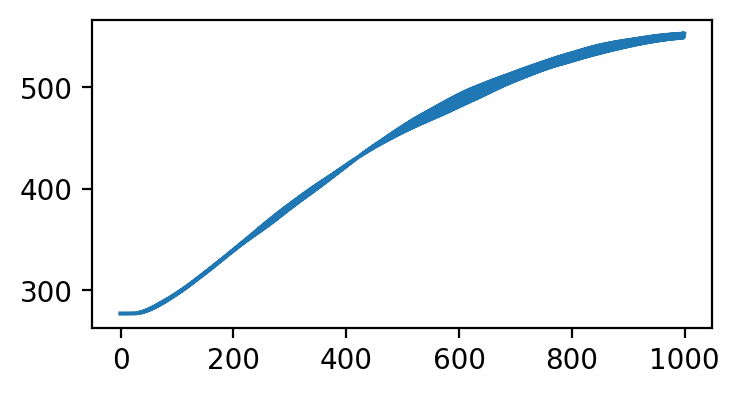

In [68]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ax.plot(tar, Xt_sim[80,:])
# ax.set_xlim(0,10)
# ax.plot(xar, Xt[:,10])

(400.0, 550.0)

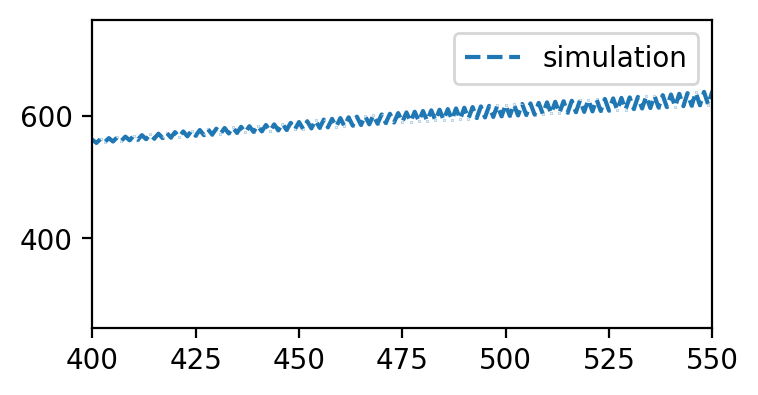

In [60]:
six = 5
fig, ax = plt.subplots(1,1 , figsize=(4,2), dpi=200)

# ax.plot(tar, Y[six,:], label='observation')
ax.plot(tar, Xt_sim[sensor_ix[six], :], label='simulation', marker='o', ls='--', ms=0.1)
# ax.plot(tar, Xt[sensor_ix[six], :], label='groundtruth', color='black')
ax.legend()
ax.set_xlim(400,550)

In [17]:
# vary s1_pos and s2_pos randomly

sim_params = default_values()
L = sim_params['L'] 
dt = sim_params['dt']
dx = sim_params['dx']
T = sim_params['T']

tar = np.arange(0,T, dt)
xar = np.arange(0,L, dx)

s1_posar = np.random.normal(1/3, 0.06, size=len(tar))
s2_posar = np.random.normal(2/3, 0.06, size=len(tar))


Xt_sim = np.zeros((len(xar), len(tar)))
Xt_sim[:,0] = 277

sensor_ix = [9, 19, 29, 39, 49, 59, 69, 79, 89]
Y = np.zeros((len(sensor_ix), len(tar)))
Y[:,0] = np.random.normal(Xt_sim[sensor_ix, 0], 5)

for tix, t in tqdm.tqdm(enumerate(tar[1:])):
    params = {'alpha': 0.5,
              'T_0': 300,
              's1_pos': s1_posar[tix+1],
              's2_pos': s2_posar[tix+1]}
    
    Xt_sim[:,tix+1] = forward_pass(params, Xt_sim[:,tix])
    Y[:,tix+1] = np.random.normal(Xt[sensor_ix, tix+1], 5)

999it [01:32, 10.83it/s]


In [8]:
Y.shape

(9, 1000)

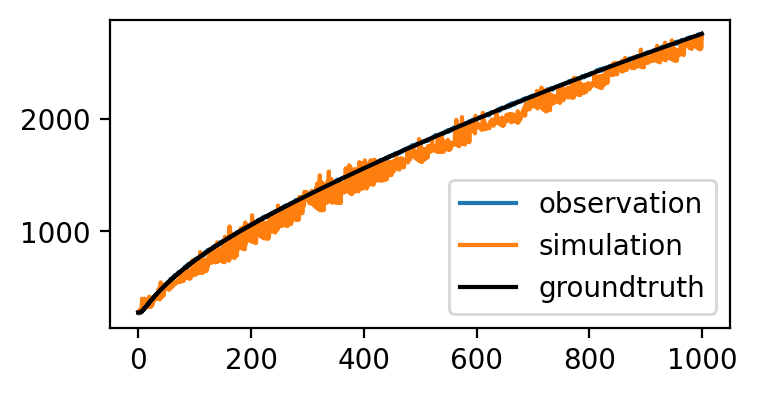

In [24]:
six = 2
fig, ax = plt.subplots(1,1 , figsize=(4,2), dpi=200)

ax.plot(tar, Y[six,:], label='observation')
ax.plot(tar, Xt_sim[sensor_ix[six], :], label='simulation')
# ax.plot(tar, Xt[sensor_ix[six], :], label='groundtruth', color='black')
ax.legend()

In [ ]:
def update_EnKF(Xt, Y):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
    Pxy = 1/(nsamples)*np.matmul(Ex, Ey.T)

    # max_Py = abs(Py).max()
    # max_Pxy = abs(Pxy).max()
    # Py /= max_Py
    # Pxy /= max_Pxy

    Py_inv = np.linalg.pinv(Py, hermitian=True)

    assert(np.allclose(np.matmul(Py_inv, Py), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    # K = np.matmul(Pxy, Py_inv)*(max_Pxy/max_Py)
    K = np.matmul(Pxy, Py_inv)

    # Note that Xt has additional +2 in it
    # Remove that with the matrix C
    C = np.zeros((Y.shape[0], Xt.shape[0]))
    sensor_ix = [9, 19, 29, 39, 49, 59, 69, 79, 89]
    
    #### Update the state ensemble
    # X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
    X = Xt + np.matmul(K, (Y - Xt[sensor_ix,:]))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X

In [ ]:
# Run 10 ensemble members
nmembers = 20
# vary s1_pos and s2_pos randomly

sim_params = default_values()
L = sim_params['L'] 
dt = sim_params['dt']
dx = sim_params['dx']
T = sim_params['T']

tar = np.arange(0,T, dt)
xar = np.arange(0,L, dx)

X = np.zeros((len(xar), len(tar)))
X[:,0] = 277

Xt_all = []
Y_all = []
X_all = [X[:,0]]

sensor_ix = [9, 19, 29, 39, 49, 59, 69, 79, 89]
for tix, t in tqdm.tqdm(enumerate(tar[1:])):
    xt = X[:,tix]
        
    Xt_member = np.zeros((len(xar), nmembers))
    Y_member = np.zeros((len(sensor_ix), nmembers))
    
    s1ar = np.random.normal(1/3, 0.06, size=nmembers)
    s2ar = np.random.normal(2/3, 0.06, size=nmembers)

    for mix in range(nmembers):
        params = {'alpha': 0.5,
              'T_0': 300,
              's1_pos': s1ar[mix],
              's2_pos': s2ar[mix]}
        
        Xt_member[:,mix] = forward_pass(params, xt)
        Y_member[:, mix] = np.random.normal(Xt[sensor_ix, tix], 5)
        
        
    X_all.append(update_EnKF(Xt_member, Y_member))
    X[:,tix+1] = X_all[-1].mean(axis=1)
    
    Xt_all.append(Xt_member)
    Y_all.append(Y_member)
    

In [ ]:
np.random.normal(Xt[sensor_ix, tix], 5)

In [ ]:
Y_all = np.array(Y_all)
Xt_all = np.array(Xt_all)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.plot(np.mean((X[sensor_ix] - Xt[sensor_ix])**2, axis=0))
ax.plot(np.mean((Xt_sim[sensor_ix] - Xt[sensor_ix])**2, axis=0))

In [ ]:
Y_all.mean(axis=2).shape

In [ ]:
six = 2
fig, ax = plt.subplots(1,1 , figsize=(4,4), dpi=200)

# for mix in range(nmembers):
ax.plot(Y_all.mean(axis=2)[::5,six], color='tab:blue', label='observation', lw=1, )
ax.plot(Xt_all.mean(axis=2)[::5,sensor_ix[six]], color='tab:orange', label='simulation', lw=1, )
# ax.plot(tar[1:], Xt_all[:, sensor_ix[six], mix], color='tab:orange', label='simulation', lw=0.2)
# ax.plot(tar, X[sensor_ix[six], :], 'k--', label='update', lw=1)
# ax.plot(tar, Xt[sensor_ix[six], :], 'r--', label='ground truth')

# ax.set_ylim(250,350)
ax.legend()

In [ ]:
Y_all.std(axis=2)


In [ ]:
Xt_all.shape

In [ ]:
six = 0
mix=2
fig, ax = plt.subplots(1,1 , figsize=(4,2), dpi=200)

ax.plot(tar[1:], Y_all[:,six,mix], color='tab:blue', label='observation')
ax.plot(tar[1:], Xt_all[:, sensor_ix[six], mix], color='tab:orange', label='simulation')
# ax.plot(tar, X[ sensor_ix[six], :], 'k--', label='update')
# ax.plot(tar, Xt[sensor_ix[six], :], 'r--', label='ground truth')

# ax.set_ylim(250,350)
ax.legend()

In [ ]:
tix = 50

fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.plot(Xt[:,tix], 'r-')
ax.plot(X[:,tix], 'k-')
ax.plot(sensor_ix, Y[:,tix], 'b--')

In [ ]:
X[sensor_ix,:10].shape

In [ ]:
xt = Xt[0,:]
xtsim = Xt_sim[0,:]

mse = np.sum((Xt_sim[sensor_ix]-Xt[sensor_ix])**2, axis=0)
plt.plot(tar[:100], mse[:100])

In [ ]:
(Xt_sim[sensor_ix]-Xt[sensor_ix])**2

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ix = 19
ax.plot(tar, Xt[ix,:])
ax.plot(tar, Xt_sim[ix,:],'r-')
ax.plot(tar, X[ix,:],'k--')
# ax.set_ylim(0,400)